In [1]:
!pip install -q underthesea

# Import Lib

In [2]:
import json
import os
import pandas as pd
import numpy as np
import re
import string
import pickle
import torch.nn as nn
from underthesea import word_tokenize, text_normalize
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import spacy
from collections import Counter
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import math
import torch.optim as optim
import time
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoModel, CLIPImageProcessor, AutoTokenizer, AutoImageProcessor, ViTModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 1
MAX_LEN = 40
EPOCHS = 7

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import file

In [3]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
        images_list = data['annotations']
        return pd.DataFrame(images_list)

In [4]:
df_train = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_train.json")
df_test = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_test.json")
df_val = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_dev.json")
# df_train = df_train.iloc[0:10]
df_val

,id,image_id,question,answers
0,74,22,cửa tiệm màu xanh là gì ?,[nhà thuốc]
1,75,22,nhà thuốc trong ảnh tên gì ?,[bảo tâm an]
2,76,22,cửa tiệm bên phải nhà thuốc chuyên gì ?,[bán sỉ và lẻ]
3,77,22,ảnh này lấy nguồn từ đâu ?,[wutacam]
4,107,30,cửa tiệm trong ảnh bán gì ?,[bếp gas]
...,...,...,...,...
5150,50295,16741,bảng này do công ty tnhh kỹ thuật nào sản xuất ?,[pmit]
5151,50296,16741,công ty pmit là công ty gì ?,[tnhh kỹ thuật]
5152,50297,16741,email của công ty pmit là gì ?,[pmit . general@gmail . com]
5153,50298,16741,số điện thoại của công ty pmit là gì ?,[0226 532544]


# Processing data

In [5]:
def format_image(root_dir, df_1):
    df_1["path"] = df_1['image_id'].apply(lambda x: os.path.join(root_dir, str(x) + ".jpg"))
    df_1 = df_1.dropna(subset=['question','answers']).copy()
    df_1['question'] = df_1['question'].astype(str)
    df_1['answers'] = df_1['answers'].astype(str)
    # df_1 = df_1.drop(["id"], axis = 1)
    df_1.reset_index(drop=True, inplace=True)
    new_columns = ["id",'image_id', "path", 'question', 'answers']
    df_1 = df_1[new_columns]
    return df_1

In [6]:
root_dir = '/kaggle/input/vitextvqa/ViTextVQA_images/st_images'
df_train = format_image(root_dir, df_train)
df_test = format_image(root_dir, df_test)
df_val = format_image(root_dir, df_val)
df_train

,id,image_id,path,question,answers
0,1,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán những món gì ?,"['mì quảng , bún bò huế']"
1,2,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán mì gì ?,['mì quảng']
2,3,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn gì bán bún gì ?,['bún bò huế']
3,4,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này địa chỉ ở đâu ?,"['13a trần quốc thảo , phường 7 , quận 3']"
4,5,1,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,tiệm trong ảnh là tiệm gì ?,['sửa xe']
...,...,...,...,...,...
35154,50338,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,cuốn sách này có tên là gì ?,['phố cổ hà nội kí họa và hồi ức']
35155,50339,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,dòng chữ ở góc trên bên phải cuốn sách này là ...,['nhiều tác giả']
35156,50340,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh viện này có tên là gì ?,['bệnh nhiệt đới trung ương']
35157,50341,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh viện này thuộc bộ nào ?,['y tế']


In [7]:
def normalize_text(text):
    clean_text = text.lower()

    replacements = {
        "[": "",
        "]": ""
    }

    for old, new in replacements.items():
        clean_text = clean_text.replace(old, new)

    # Xóa ký tự đặc biệt VD (&nbsp;)
    clean_text = re.sub(r'&\S+;', ' ', clean_text)

    # Xóa emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)
    clean_text = re.sub(emoji_pattern, " ", clean_text)

    # Xóa ký tự đặc biệt không gõ được
    special_chars = ["“", "”", "…", "•", "–", "’", " ️", "✅", "✓", " ̂́ ̃ ̣̂ ", "‘", "●", "‒", "➤",
                     "★", "ღ", "✪", "‎", "➦", "×", "", "✿", "☆", "◤", "◕", "❁", "‿",
                     "❀", "■", "█", "☛", "⑴⒪⑵⑵⑴⑺", "►", "°", "»", "ø", "➽", "", "✧", "✽", "*",
                     "➫", "【", "】", "⇒", "卐", "♛", "±", "∞", "②", "⑥", "①", "⑦", "➋", "➊", "➌",
                     "✓", "™", "®", "", "'"]
    for char in special_chars:
        clean_text = clean_text.replace(char, " ")

    # # Bỏ các ký tự đặc biệt (dấu câu)
    # clean_text = ''.join(' ' if char in string.punctuation else char for char in clean_text)

    # Loại bỏ khoảng trắng thừa
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = re.sub(r"^[\s]", "", clean_text)
    clean_text = re.sub(r"[\s]$", "", clean_text)

    # Đảm bảo dấu ở đúng chữ (ví dụ: oà, uý)
    clean_text = text_normalize(clean_text)

    # Tách câu thành từ
    clean_text = word_tokenize(clean_text, format="text")

    return clean_text

def apply_normalize_text_to_dataframe(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: normalize_text(str(x)))
    return df

In [8]:
columns_to_process = ['question', 'answers']
df_train = apply_normalize_text_to_dataframe(df_train, columns_to_process)
df_test = apply_normalize_text_to_dataframe(df_test, columns_to_process)
df_val = apply_normalize_text_to_dataframe(df_val, columns_to_process)
df_train

,id,image_id,path,question,answers
0,1,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán những món gì ?,"mì quảng , bún_bò huế"
1,2,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán mì gì ?,mì quảng
2,3,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn gì bán bún gì ?,bún bò huế
3,4,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này địa_chỉ ở đâu ?,"13 a_trần quốc_thảo , phường 7 , quận 3"
4,5,1,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,tiệm trong ảnh là tiệm gì ?,sửa xe
...,...,...,...,...,...
35154,50338,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,cuốn sách này có tên là gì ?,phố cổ hà_nội kí_họa và hồi_ức
35155,50339,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,dòng chữ ở góc trên bên phải cuốn sách này là ...,nhiều tác_giả
35156,50340,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh_viện này có tên là gì ?,bệnh nhiệt_đới trung_ương
35157,50341,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh_viện này thuộc bộ nào ?,y_tế


# Data visualization

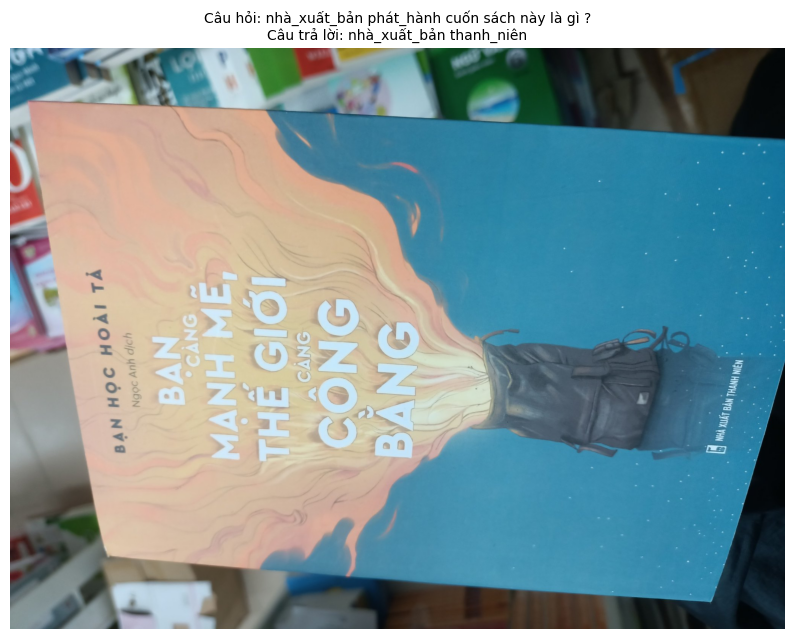

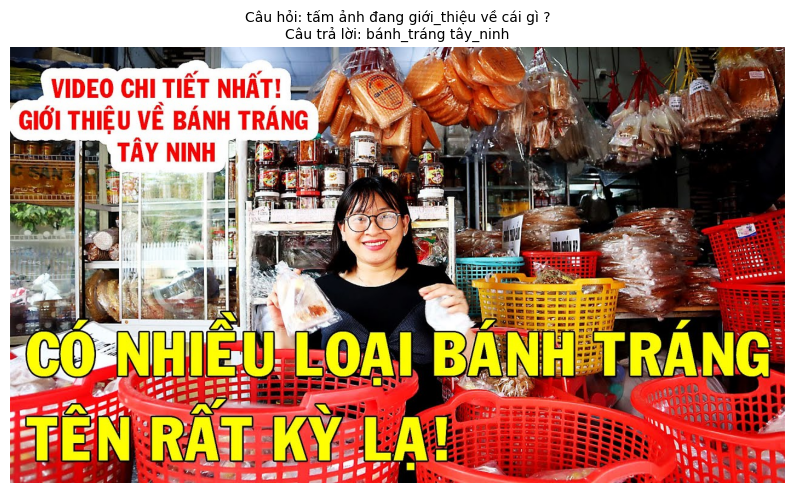

In [9]:
samples = df_train.sample(n=random.randint(2, min(2, len(df_train)))).reset_index(drop=True)

for i, row in samples.iterrows():
    image = row['path']
    question = row['question']
    answer = row['answers']

    try:
        # Mở và hiển thị hình ảnh
        img = Image.open(image)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Câu hỏi: {question}\nCâu trả lời: {answer}", fontsize=10)
        plt.axis('off')  # Ẩn trục để hiển thị gọn gàng hơn
        plt.show()
    except FileNotFoundError:
        print(f"Không tìm thấy hình ảnh: {image}")
    except Exception as e:
        print(f"Lỗi khi tải hình ảnh {image}: {e}")

In [10]:
def get_sentence_length(text):
    if not isinstance(text, str):
        return 0
    tokens = word_tokenize(text)
    return len(tokens)

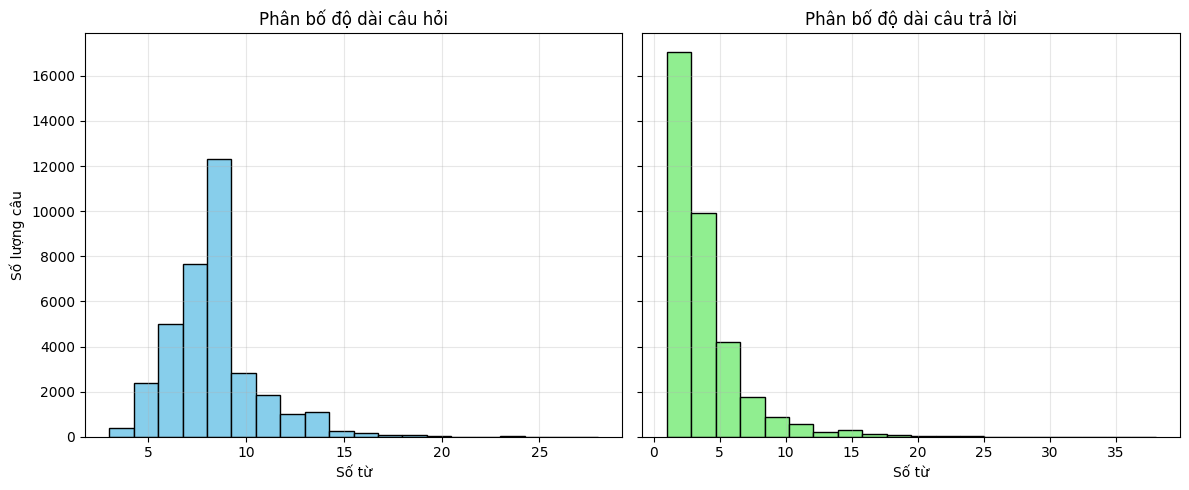

In [11]:
question_lengths = df_train['question'].apply(get_sentence_length).tolist()
answer_lengths = df_train['answers'].apply(get_sentence_length).tolist()

# Thiết lập bố cục subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 1: Độ dài câu hỏi
ax1.hist(question_lengths, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Phân bố độ dài câu hỏi')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Số lượng câu')
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Độ dài câu trả lời
ax2.hist(answer_lengths, bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Phân bố độ dài câu trả lời')
ax2.set_xlabel('Số từ')
ax2.grid(True, alpha=0.3)

# Tùy chỉnh khoảng cách giữa các subplot
plt.tight_layout()

# Tokenize

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
vocab = tokenizer.get_vocab()
len(vocab)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


64001

# Change form to dataset

In [13]:
class VLSP_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anno_id, img_id, image_path, question, answer = self.data.iloc[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return anno_id, img_id, image, question, answer

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    # transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


train_vlsp_dataset = VLSP_Dataset(df_train, transform=transform)
test_vlsp_dataset = VLSP_Dataset(df_test, transform=transform)

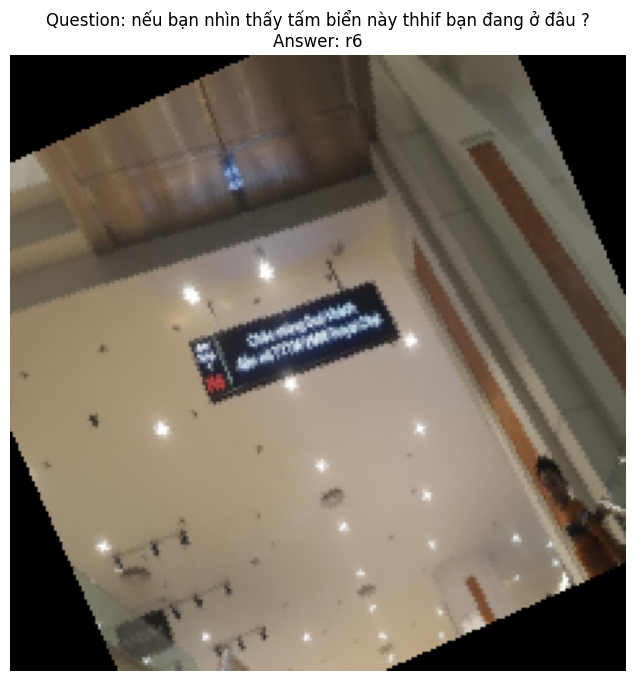

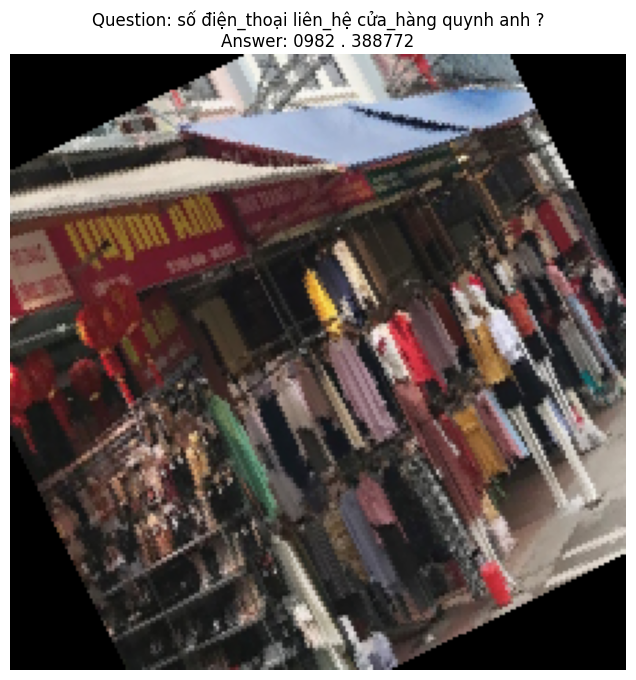

In [15]:
random_indices = np.random.choice(len(train_vlsp_dataset), 2)

for idx in random_indices:
    anno_id, img_id, image, question, answer = train_vlsp_dataset[idx]
    
    image = image.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title("Question: " + question + "\nAnswer: " + answer)
    plt.axis('off')
    plt.show()

In [16]:
train_loader = DataLoader(train_vlsp_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_vlsp_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
len(train_loader), len(test_loader)

(2198, 10028)

In [17]:
anno_id, img_id, image, quesiton, answer = next(enumerate(train_loader))[1]
len(answer), len(image), len(quesiton)

(16, 16, 16)

# Using Pretrain for VQA

### Image Embedding: ViT

In [18]:
image_model_name = "google/vit-base-patch16-224-in21k"
class ImageEmbedding(nn.Module):
    def __init__(self):
        super(ImageEmbedding, self).__init__()
        self.process = AutoImageProcessor.from_pretrained(image_model_name)
        self.model = ViTModel.from_pretrained(image_model_name)
        #self.model = nn.Sequential(*list(self.model.children())[:3])
        
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, image, image_ids):
        inputs = self.process(image, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs.to(device))
            
        image_embedding = outputs.last_hidden_state
        return image_embedding, image_ids

### Question Embedding: PhoBert

In [19]:
text_model_name = "vinai/phobert-base"
class QuesEmbedding(nn.Module):
    def __init__(self, input_size=768, output_size=768):
        super(QuesEmbedding, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.phobert = AutoModel.from_pretrained(text_model_name)
        self.lstm = nn.LSTM(input_size, output_size, batch_first=True)

    def forward(self, ques):
        tokenized_input = self.tokenizer(ques, 
                                         return_tensors='pt', 
                                         padding='max_length', 
                                         max_length=MAX_LEN, 
                                         truncation=True, 
                                         add_special_tokens=False)
        ques = self.phobert(**tokenized_input.to(device)).last_hidden_state
        _, (h, _) = self.lstm(ques)
        return h.squeeze(0)

### Test Batch 

In [20]:
image_model = ImageEmbedding().to(device)
ques_model = QuesEmbedding().to(device)

for batch in train_loader:
    anno_ids, img_ids, images, questions, answers = batch
    if torch.cuda.is_available():
        images = images.cuda()
        questions = questions
        anno_ids = anno_ids
    
    with torch.no_grad():
        image_embeddings, att_ids = image_model(images, image_ids=anno_ids)
        ques_embeddings = ques_model(questions)
    break    

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [21]:
print(image_embeddings.size())
print(att_ids.size())
print(ques_embeddings.size())

torch.Size([16, 197, 768])
torch.Size([16])
torch.Size([16, 768])


In [22]:
image_embeddings = image_embeddings.reshape(TRAIN_BATCH_SIZE, 768, -1).permute(0, 2, 1)
ques_embeddings = ques_embeddings.unsqueeze(1)
print(image_embeddings.size())
print(ques_embeddings.size())

torch.Size([16, 197, 768])
torch.Size([16, 1, 768])


# Stack Attention Networks

In [23]:
#Linear để giảm kích thước, không cần tile repeat mà đưa vào san để nhân luôn cuối cùng trả về vector attention mà ko cần phải flatten
class StackAttention(nn.Module):
    def __init__(self, d=768, k=512, dropout=True):
        super(StackAttention, self).__init__()
        self.ff_image = nn.Linear(d, k)
        self.ff_ques = nn.Linear(d, k)
        if dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.ff_attention = nn.Linear(k, 1)

    def forward(self, vi, vq):
        # N * 49 * 768 -> N * 49 * 512
        hi = self.ff_image(vi)
        #print("hi size: ", hi.size())
        # N * 768 -> N * 512 -> N * 1 * 512
        hq = self.ff_ques(vq)
        #print("hq size: ", hq.size())
        # N * 49 * 512
        ha = F.tanh(hi + hq)
        #print("ha1 size: ", ha.size())
        if getattr(self, 'dropout'):
            ha = self.dropout(ha)
        #DONE
        
        # N * 49 * 512 -> N * 49 * 1 -> N * 49
        ha = self.ff_attention(ha).squeeze(dim=2)
        #print("ha2 size: ", ha.size())
        pi = F.softmax(ha)
        # (N * 49 * 1, N * 49 * 768) -> N * 768
        vi_attended = (pi.unsqueeze(dim=2) * vi).sum(dim=1)
        #print("vi~ size: ", vi_attended.size())
        #print("vq size: ", vq.size())
        u = vi_attended + vq.squeeze(1)
        return u

In [24]:
san_model = StackAttention(d=768, k=512, dropout=True).to(device)
img_text_att = san_model(image_embeddings.to(device), ques_embeddings.to(device))
img_text_att.size()

/tmp/ipykernel_26/2416429134.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(ha)


torch.Size([16, 768])

# Generate Answer

## Answers Embedding

In [25]:
class AnsEmbedding(nn.Module):
    def __init__(self, input_size=768):
        super(AnsEmbedding, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.phobert_embed = AutoModel.from_pretrained(text_model_name).embeddings.to(device)

    def forward(self, ans):  
        tokenized_input = self.tokenizer(ans, 
                                         return_tensors='pt',
                                         padding='max_length', 
                                         max_length=MAX_LEN, 
                                         truncation=True, return_attention_mask=False)
        ans = self.phobert_embed(**tokenized_input.to(device))
        return tokenized_input['input_ids'], ans

In [26]:
ans_model = AnsEmbedding().to(device)

for batch in train_loader:
    anno_id, img_id, images, questions, answers = batch
    if torch.cuda.is_available():
        answers = answers
    with torch.no_grad():
        ans_tokens, answers_embedding = ans_model(answers)
    break   
ans_tokens.size(), answers_embedding.size() 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(torch.Size([16, 40]), torch.Size([16, 40, 768]))

In [27]:
print(answers_embedding.size())
print(img_text_att.size())

torch.Size([16, 40, 768])
torch.Size([16, 768])


# Decoder

In [28]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1] 
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) 
    if mask is not None:
        scaled += mask 
    attention = F.softmax(scaled, dim=-1) 
    values = torch.matmul(attention, v)
    return values, attention


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        return x


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # 512

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        mean = inputs.mean(dim=dims, keepdim=True) 
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt() 
        y = (inputs - mean) / std 
        out = self.gamma * y  + self.beta  
        return out

class MaskMultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model) 
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size() 
        qkv = self.qkv_layer(x) 
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) 
        q, k, v = qkv.chunk(3, dim=-1) 
        values, attention = scaled_dot_product(q, k, v, mask) 
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) 
        out = self.linear_layer(values) # 30 x 200 x 512
        return out # 30 x 200 x 512


class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x) 
        q = self.q_layer(y) 
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) 
        kv = kv.permute(0, 2, 1, 3) 
        q = q.permute(0, 2, 1, 3) 
        k, v = kv.chunk(2, dim=-1) 
        values, attention = scaled_dot_product(q, k, v, mask) 
        values = values.reshape(batch_size, sequence_length, d_model) 
        out = self.linear_layer(values)
        return out  


class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MaskMultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, decoder_mask):
        _y = y
        y = self.self_attention(y, mask=decoder_mask)
        y = self.dropout1(y)
        y = self.norm1(y + _y)

        _y = y # 30 x 200 x 512
        y = self.encoder_decoder_attention(x, y, mask=None)
        y = self.dropout2(y)
        y = self.norm2(y + _y)

        _y = y 
        y = self.ffn(y) 
        y = self.dropout3(y)
        y = self.norm3(y + _y) 
        return y 

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x, y, mask)
        return y

class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) 
                                          for _ in range(num_layers)])

    def forward(self, x, y, mask):
        y = self.layers(x, y, mask)
        return y

In [29]:
d_model = 768
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = MAX_LEN
ffn_hidden = 2048
num_layers = 5

x = img_text_att.unsqueeze(1).expand(-1, max_sequence_length, -1).to(device) # 16 * 768 -> 16 * 48 * 1024
y = answers_embedding.to(device) #16 * 48 * 768
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
mask = torch.triu(mask, diagonal=1).to(device)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers).to(device)
out = decoder(x, y, mask).to(device)

In [30]:
vocab_size = len(vocab)

linear_layer = nn.Linear(d_model, vocab_size).to(device)
output_logits = linear_layer(out)
output_probs = F.softmax(output_logits, dim=2)
output_probs.size()

torch.Size([16, 40, 64001])

### Test predict and tokenizer with 1 batch

In [31]:
from transformers import PhobertTokenizer
tokenizer = PhobertTokenizer.from_pretrained("vinai/phobert-base")

decoder_output = output_probs
predicted_tokens = decoder_output.argmax(dim=2)

def tokens_to_text(tokens, tokenizeFcr):
    return [tokenizer.decode(token.item()) for token in tokens]

for i in range(16):
    generated_text = tokens_to_text(predicted_tokens[i], tokenizer)
    print(f"Generated text for example {i}: {' '.join(generated_text)}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated text for example 0: t i ê u _ t a n n h i ế c U n i v e r s i t y _ @ @ M u r i @ @ I C S 3 7 % n ấ m _ m ố c k h á t _ v ọ n g N g u ồ n D r e s d e n o g r a p h y o g r a p h y T h à n h _ q u ả y a n u a g i á _ s à n h o à n g _ @ @ T h u ý _ D i ễ m h o à n g _ @ @ 3 / 2 0 1 3 u ậ n _ @ @ g i á _ s à n c ò @ @ c ò @ @ c ò @ @ c ò @ @ 3 0 / 4 à o _ à o B ă n g B ă n g B ă n g T h i ề u V õ _ t h u ậ t f f y g i á _ s à n k h á t _ v ọ n g L ã _ T h a n h _ H u y ề n g i á _ s à n K ỳ _ v ọ n g i ệ n _ t @ @ i ệ n _ t @ @
Generated text for example 1: I n s i d e r B ắ c l ồ n g _ t i ế n g b à i _ t i ế t I C S k ỵ @ @ c ấ p _ b á o P h i l i p p _ @ @ n ế m V i n a l @ @ n ấ m _ m ố c M ỗ @ @ y a n u a y a n u a B ắ t _ @ @ V N Đ l i m u ậ n _ @ @ 3 7 % 3 / 2 0 1 3 t h ừ a _ h ư ở n g K ỳ _ v ọ n g c ò @ @ R ằ n g c ò @ @ T h u ý _ D i ễ m T h u ý _ D i ễ m D r e s d e n h i s @ @ B ă n g c ò @ @ 3 7 % u ậ n _ @ @ t h ạ c h X u n g _ đ ộ t N h â n _ T ô n g N h â n _ T 

# VQA Model

In [32]:
class VQAModel(nn.Module):

    def __init__(self, vocab_size=64001, output_size=768, d_model=768, num_head=8, ffn_hidden=2048, drop_prob=0.3, num_layers=6, num_att_layers=4, mode='train'):
        super(VQAModel, self).__init__()
        self.mode = mode
        self.image_model = ImageEmbedding().to(device)
        self.ques_model = QuesEmbedding().to(device)
        self.ans_model = AnsEmbedding().to(device)
        
        self.san_model = nn.ModuleList(
            [StackAttention(d=d_model, k=512, dropout=True)] * num_att_layers).to(device)
        
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers).to(device)
        
        self.mlp = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(d_model, vocab_size))

    def forward(self, images, questions, answers, anno_ids, mask, mode, max_len=MAX_LEN):
        image_embeddings, att_ids = self.image_model(images.to(device), image_ids=anno_ids)
        if mode == 'train':
            image_embedds = image_embeddings.reshape(TRAIN_BATCH_SIZE, 768, -1).permute(0, 2, 1)
        else:
            image_embedds = image_embeddings.reshape(VAL_BATCH_SIZE, 768, -1).permute(0, 2, 1)
        
        ques_embeddings = self.ques_model(questions)
        ques_embedds = ques_embeddings.unsqueeze(1)
        
        for att_layer in self.san_model:
            att_embedds = att_layer(image_embedds.to(device), ques_embedds.to(device))
        
        att_embedds = self.tanh(att_embedds)
        att_embedds = self.dropout(att_embedds)
        
        #START DECODER
        ans_vocab, ans_embedds = self.ans_model(answers)
        
        x = att_embedds.to(device).unsqueeze(1).expand(-1, max_len, -1).to(device) # 16 * 768 -> 16 * 48 * 768
        y = ans_embedds # 16 * 48 * 768
        #print(x)
        #print(y.size())
        if mask == False:
            out = self.decoder(x, y, mask=None).to(device)
        else:
            mask = torch.full([max_len, max_len] , float('-inf'))
            mask = torch.triu(mask, diagonal=1).to(device)
        
            out = self.decoder(x, y, mask).to(device)
        #END DECODER
        #print(out)
        output_logits = self.mlp(out)
        return output_logits, ans_vocab

## Training

In [33]:
model = VQAModel().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 286,348,290 trainable parameters.


In [35]:
vocab_swap = {value: key for key, value in vocab.items()}

In [36]:
def load_checkpoint_train(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    # for parameter in model.parameters():
    #     parameter.requires_grad = False
    
    model.train()
    
    return model

model = load_checkpoint_train('/kaggle/input/model-vqa-cv/ViT_PhoBert_v2.pt').to(device)

In [37]:
num_epochs = EPOCHS
print_every = 500

losses = []
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train() 
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        anno_id, img_id, images, questions, answers = batch
        if len(images) == TRAIN_BATCH_SIZE:
            predicted_tokens, ans_embedds = model(images.to(device), questions, answers, anno_id, mode='train', mask=True)
            predicted_tokens = predicted_tokens.float()
            ans_embedds = ans_embedds.long()
            
            for i in range(TRAIN_BATCH_SIZE):
                sentence_predicted = torch.argmax(predicted_tokens[i], axis=1)
                predicted_sentence = ""
                for idx in sentence_predicted:
                    predicted_sentence += vocab_swap[idx.item()] + " "
                    if idx == 2:
                        break
                if (batch_idx + 1) % print_every == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
                    print(f"Question: {questions[i]}")
                    print(f"Answer: {answers[i]}")
                    print(f"Answer Prediction: {predicted_sentence}")
                    break
    
            loss = criterion(predicted_tokens.permute(0, 2, 1), ans_embedds)
            #valid_indicies = torch.where(ans_embedds == 1, False, True)
            #loss = loss.sum() / valid_indicies.sum()

            optimizer.zero_grad()
            # print(loss.requires_grad)  # Should be True
            # print(loss.grad_fn)        # Should not be None
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            losses.append(loss.item())
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_26/2416429134.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(ha)
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/7], Batch [500/2198], Loss: 1.4147
Question: cửa_hàng bên trái là cửa_hàng gì ?
Answer: bách_hóa tổng_hợp
Answer Prediction: <s> bá@@ ch@@ _h@@ ó@@ a tổng_hợp </s> 
Epoch [1/7], Batch [1000/2198], Loss: 1.5655
Question: tấm bảng trắng trước cổng hội_chợ nói về gì ?
Answer: giữ xe hội_chợ
Answer Prediction: <s> giữ xe hội_chợ </s> 
Epoch [1/7], Batch [1500/2198], Loss: 1.3310
Question: cửa_hàng có biển màu trắng_bản sản_phẩm gì ?
Answer: bia lợi béo
Answer Prediction: <s> bia lợi béo </s> 
Epoch [1/7], Batch [2000/2198], Loss: 1.1963
Question: đồng sơn không bảo_hiểm khi tham_gia chương_trình có mã khuyến_mãi là bao_nhiêu ?
Answer: 20 %
Answer Prediction: <s> 20 % </s> 


Epochs:  14%|█▍        | 1/7 [30:38<3:03:49, 1838.25s/it]

Epoch [1/7], Average Loss: 1.1315
Epoch [2/7], Batch [500/2198], Loss: 1.1973
Question: bức hình nói về gì ?
Answer: chiếc khẩu_trang mỉm cười
Answer Prediction: <s> xe khẩu_trang se@@ cười </s> 
Epoch [2/7], Batch [1000/2198], Loss: 0.9096
Question: khách_sạn hà_nội sahul ở đâu ?
Answer: hà_nội
Answer Prediction: <s> hà_@@ nội </s> 
Epoch [2/7], Batch [1500/2198], Loss: 0.7752
Question: dòng chữ góc dưới bên phải bức ảnh là gì ?
Answer: vietsense crawl
Answer Prediction: <s> viet@@ sen@@ se tr@@ w@@ l </s> 
Epoch [2/7], Batch [2000/2198], Loss: 0.8430
Question: số điện_thoại chính_thức của viettel ?
Answer: 1800 . 8000
Answer Prediction: <s> 1800 . tô@@ </s> 


Epochs:  29%|██▊       | 2/7 [58:55<2:26:15, 1755.04s/it]

Epoch [2/7], Average Loss: 1.1319
Epoch [3/7], Batch [500/2198], Loss: 0.4474
Question: cửa_hàng popeyes bán loại đồ_ăn gì ?
Answer: gà rán
Answer Prediction: <s> gà rán </s> 
Epoch [3/7], Batch [1000/2198], Loss: 1.6062
Question: cửa_hàng bảng_hiệu màu xanh lá bên trái điện máy xanh là gì ?
Answer: bách_hóa xanh
Answer Prediction: <s> bá@@ ch@@ _h@@ ó@@ a xanh </s> 
Epoch [3/7], Batch [1500/2198], Loss: 1.3596
Question: cửa_hàng này có tên là gì ?
Answer: tân_tiến 2
Answer Prediction: <s> tân_tiến 2 </s> 
Epoch [3/7], Batch [2000/2198], Loss: 0.7085
Question: cửa_hàng trong ảnh tên là gì ?
Answer: bitis
Answer Prediction: <s> bi@@ hải </s> 


Epochs:  43%|████▎     | 3/7 [1:27:10<1:55:11, 1727.86s/it]

Epoch [3/7], Average Loss: 1.1343
Epoch [4/7], Batch [500/2198], Loss: 1.0981
Question: khu chợ này tên gì ?
Answer: đồng xuân
Answer Prediction: <s> đồng xuân </s> 
Epoch [4/7], Batch [1000/2198], Loss: 0.8099
Question: website của vietnamnet là gì ?
Answer: vietnamnet . vn
Answer Prediction: <s> vietnam@@ net . vn </s> 
Epoch [4/7], Batch [1500/2198], Loss: 0.8784
Question: số hotline thứ nhất để liên_hệ với yamaguchi là gì ?
Answer: 036 456 8777
Answer Prediction: <s> 0@@ 36 456 8@@ 777 </s> 
Epoch [4/7], Batch [2000/2198], Loss: 1.4406
Question: vy văn_tiến có chức_vụ gì ?
Answer: phó chủ_tịch hđnd
Answer Prediction: <s> phó chủ_tịch h@@ đ@@ nd </s> 


Epochs:  57%|█████▋    | 4/7 [1:55:21<1:25:39, 1713.28s/it]

Epoch [4/7], Average Loss: 1.1340
Epoch [5/7], Batch [500/2198], Loss: 1.0648
Question: cửa_hàng này bán những mặt_hàng gì ?
Answer: hàng_tiêu_dùng
Answer Prediction: <s> hàng_tiêu_dùng </s> 
Epoch [5/7], Batch [1000/2198], Loss: 1.2984
Question: ngày buổi hội_nghị diễn ra ?
Answer: ngày 12 tháng 8 năm 2020
Answer Prediction: <s> ngày 12 tháng 8 năm 2020 </s> 
Epoch [5/7], Batch [1500/2198], Loss: 0.9093
Question: cuốn sách này có tên là gì ?
Answer: nhật_ký chú bé nhút_nhát bỉm toang
Answer Prediction: <s> hiền chú bé nội bỉm 00@@ </s> 
Epoch [5/7], Batch [2000/2198], Loss: 0.6046
Question: số điện_thoại liên_hệ với nhà_sách là gì ?
Answer: ( 0276 ) . 625 . 255
Answer Prediction: <s> ( 0@@ 58 ) . 6@@ . 255 </s> 


Epochs:  71%|███████▏  | 5/7 [2:23:28<56:47, 1703.89s/it]  

Epoch [5/7], Average Loss: 1.1353
Epoch [6/7], Batch [500/2198], Loss: 1.5430
Question: quán 34 là quán gì ?
Answer: chay
Answer Prediction: <s> chay </s> 
Epoch [6/7], Batch [1000/2198], Loss: 0.7579
Question: điện_biên là điểm hẹn ở đâu ?
Answer: nơi cực_tây tổ_quốc
Answer Prediction: <s> nơi siêu ây tổ_quốc </s> 
Epoch [6/7], Batch [1500/2198], Loss: 0.7507
Question: chợ này có tên là gì ?
Answer: tình khâu vai
Answer Prediction: <s> tình hồ kh@@ </s> 
Epoch [6/7], Batch [2000/2198], Loss: 1.5319
Question: tựa đề của quyển sách này là gì ?
Answer: những mùa hoa cỏ_tranh
Answer Prediction: <s> những mùa hoa mua_bán vi@@ </s> 


Epochs:  86%|████████▌ | 6/7 [2:51:25<28:14, 1694.73s/it]

Epoch [6/7], Average Loss: 1.1336
Epoch [7/7], Batch [500/2198], Loss: 0.9624
Question: tiêu_đề của bài báo này là gì ?
Answer: nóng : công_an đang bao_vây , khám_xét 2 địa_điểm ở biên_hòa
Answer Prediction: <s> nóng : công_an đang chanh , vn 2 địa_điểm ở biên_@@ hò@@ a </s> 
Epoch [7/7], Batch [1000/2198], Loss: 1.1580
Question: cửa_hàng này có tên là gì ?
Answer: a2z
Answer Prediction: <s> a@@ 2@@ z </s> 
Epoch [7/7], Batch [1500/2198], Loss: 0.9998
Question: đây là đài gì ?
Answer: thánh_an tôn
Answer Prediction: <s> rẻ an tôn </s> 
Epoch [7/7], Batch [2000/2198], Loss: 1.0353
Question: cửa_hàng này có bán những gì ?
Answer: chuyên_sỉ - lẻ kính - đồng_hồ tóc giả - quần_áo - phụ kiện
Answer Prediction: <s> chuyên_@@ sỉ - lẻ kính - đồng_hồ tóc giả - quần_áo - phụ kiện </s> 


Epochs: 100%|██████████| 7/7 [3:19:18<00:00, 1708.42s/it]

Epoch [7/7], Average Loss: 1.1310


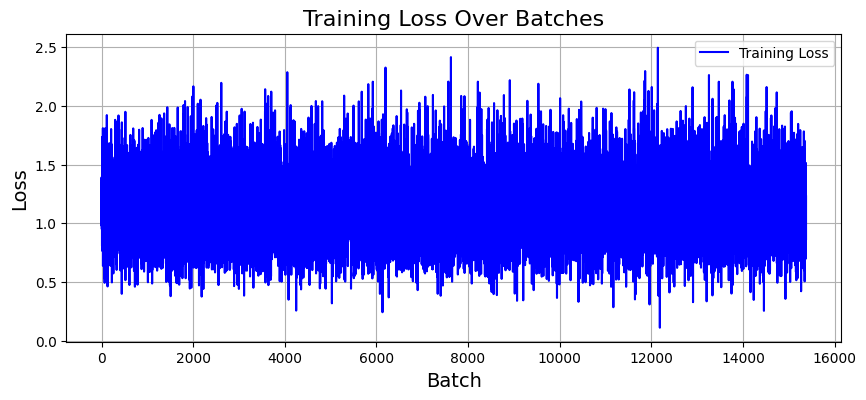

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Batch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Over Batches', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [39]:
checkpoint = {'model': VQAModel(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, '/kaggle/working/ViT_PhoBert.pt')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
